In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import math 
from collections import Counter
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten

In [2]:
df = pd.read_csv('TitleDataSet/final_data.csv', header=None)

In [3]:
df[0] = df[0].str.lower()
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)          #url
df[0] = df[0].str.replace('\n',' ')                                   #lines
df[0] = df[0].str.replace('[^\w\s]',' ')                              #punctuations
df[0] = df[0].str.replace('\d','')                                    #int
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji

C:\Users\ashch\AppData\Local\Temp\ipykernel_9296\2662738091.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)          #url
C:\Users\ashch\AppData\Local\Temp\ipykernel_9296\2662738091.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s]',' ')                              #punctuations
C:\Users\ashch\AppData\Local\Temp\ipykernel_9296\2662738091.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('\d','')                                    #int
C:\Users\ashch\AppData\Local\Temp\ipykernel_9296\2662738091.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji


In [4]:
spell = Speller(lang='en')
def typo_corrector(text):
    return spell(text)
df[0] = df[0].apply(typo_corrector)

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)
df[0] = df[0].apply(lemmatize_text)

In [29]:
stop = stopwords.words('english')
neg = ['no','not']
interrogative = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am','are','could','would','should','can','did','does','do','had','have']
imperative = ['could','would','should','can']

forNegative = stop.copy()
for word in neg:
    if word in forNegative:
        forNegative.remove(word)
forInterrogative = stop.copy()
for word in interrogative:
    if word in forInterrogative:
        forInterrogative.remove(word)    
forImperative = stop.copy()
for word in imperative:
    if word in forImperative:
        forImperative.remove(word)

for i in range(len(df)):
    if df[1][i] == "negative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in forNegative])
for i in range(len(df)):
    if df[1][i] == "interrogative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in forInterrogative])
for i in range(len(df)):
    if df[1][i] == "imperative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in forImperative])
for i in range(len(df)):
    if df[1][i] == "positive" or df[1][i] == "other":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in stop])

In [30]:
maxWords = 50000
maxSeq = 250
embVec = 100
tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df[0].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8986 unique tokens.


In [31]:
from keras.preprocessing.sequence import pad_sequences
features = tokenizer.texts_to_sequences(df[0].values)
features = pad_sequences(features, maxSeq)
labels = pd.get_dummies(df[1]).values

In [32]:
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'other', 'negative'],
      dtype=object)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [34]:
model1 = Sequential()
model1.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(5, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 dense_9 (Dense)             (None, 250, 128)          12928     
                                                                 
 dropout_3 (Dropout)         (None, 250, 128)          0         
                                                                 
 dense_10 (Dense)            (None, 250, 128)          16512     
                                                                 
 dropout_4 (Dropout)         (None, 250, 128)          0         
                                                                 
 dense_11 (Dense)            (None, 250, 64)           8256      
                                                                 
 dropout_5 (Dropout)         (None, 250, 64)          

In [35]:
history1 = model1.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
200/200 [==============================] - 28s 140ms/step - loss: 1.0072 - accuracy: 0.5984 - val_loss: 0.6848 - val_accuracy: 0.7613
Epoch 2/5
200/200 [==============================] - 29s 145ms/step - loss: 0.6088 - accuracy: 0.7837 - val_loss: 0.6406 - val_accuracy: 0.7850
Epoch 3/5
200/200 [==============================] - 26s 132ms/step - loss: 0.4752 - accuracy: 0.8383 - val_loss: 0.6589 - val_accuracy: 0.7825
Epoch 4/5
200/200 [==============================] - 26s 131ms/step - loss: 0.3670 - accuracy: 0.8766 - val_loss: 0.7143 - val_accuracy: 0.7825
Epoch 5/5
200/200 [==============================] - 27s 135ms/step - loss: 0.2945 - accuracy: 0.9022 - val_loss: 0.7950 - val_accuracy: 0.7887


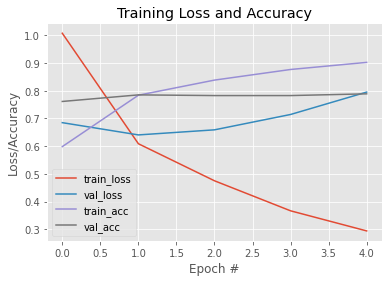

In [36]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), history1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), history1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), history1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), history1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [37]:
model1.evaluate(X_test, y_test, batch_size=20, verbose=2)   #[0.8276503086090088, 0.7705000042915344]

100/100 - 1s - loss: 0.8277 - accuracy: 0.7705 - 981ms/epoch - 10ms/step


[0.8276503086090088, 0.7705000042915344]

In [38]:
model2 = Sequential()
model2.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model2.add(LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
model2.add(LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=False))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 lstm_5 (LSTM)               (None, 250, 32)           17024     
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dense_13 (Dense)            (None, 100)               3300      
                                                                 
 dense_14 (Dense)            (None, 5)                 505       
                                                                 
Total params: 5,029,149
Trainable params: 5,029,149
Non-trainable params: 0
_________________________________________________________________


In [39]:
history2 = model2.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 77s 366ms/step - loss: 0.3926 - acc: 0.5130 - val_loss: 0.2530 - val_acc: 0.7006
Epoch 2/10
200/200 [==============================] - 60s 299ms/step - loss: 0.2143 - acc: 0.7655 - val_loss: 0.2068 - val_acc: 0.7894
Epoch 3/10
200/200 [==============================] - 59s 294ms/step - loss: 0.1717 - acc: 0.8270 - val_loss: 0.1899 - val_acc: 0.7981
Epoch 4/10
200/200 [==============================] - 64s 321ms/step - loss: 0.1492 - acc: 0.8503 - val_loss: 0.1874 - val_acc: 0.8044
Epoch 5/10
200/200 [==============================] - 59s 296ms/step - loss: 0.1320 - acc: 0.8673 - val_loss: 0.1940 - val_acc: 0.8087
Epoch 6/10
200/200 [==============================] - 72s 359ms/step - loss: 0.1157 - acc: 0.8855 - val_loss: 0.2056 - val_acc: 0.8163
Epoch 7/10
200/200 [==============================] - 76s 380ms/step - loss: 0.1008 - acc: 0.9061 - val_loss: 0.2254 - val_acc: 0.8119
Epoch 8/10
200/200 [==============================] - 6

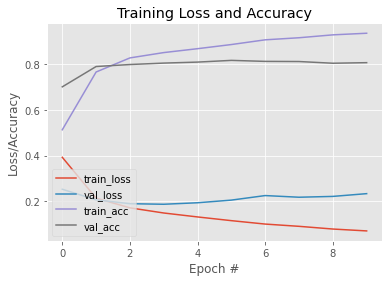

In [40]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), history2.history["acc"], label="train_acc")
plt.plot(np.arange(0, 10), history2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [41]:
model2.evaluate(X_test, y_test, batch_size=20, verbose=2)    #[0.25312358140945435, 0.7929999828338623]

100/100 - 4s - loss: 0.2531 - acc: 0.7930 - 4s/epoch - 42ms/step


[0.25312358140945435, 0.7929999828338623]

In [42]:
model3 = Sequential()
model3.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
history3 = model3.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
200/200 [==============================] - 104s 511ms/step - loss: 0.9803 - accuracy: 0.6164 - val_loss: 0.6648 - val_accuracy: 0.7525
Epoch 2/5
200/200 [==============================] - 109s 543ms/step - loss: 0.5815 - accuracy: 0.7925 - val_loss: 0.5974 - val_accuracy: 0.7912
Epoch 3/5
200/200 [==============================] - 109s 547ms/step - loss: 0.4698 - accuracy: 0.8347 - val_loss: 0.5186 - val_accuracy: 0.8138
Epoch 4/5
200/200 [==============================] - 112s 559ms/step - loss: 0.3882 - accuracy: 0.8667 - val_loss: 0.4938 - val_accuracy: 0.8369
Epoch 5/5
200/200 [==============================] - 109s 543ms/step - loss: 0.3161 - accuracy: 0.8900 - val_loss: 0.5133 - val_accuracy: 0.8394


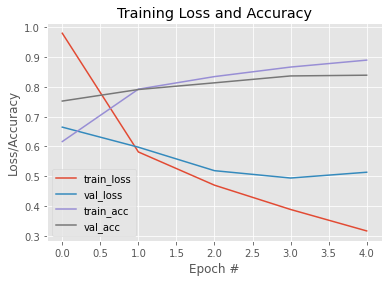

In [44]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), history3.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), history3.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), history3.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), history3.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [48]:
model3.evaluate(X_test, y_test, batch_size=20, verbose=2)   #[0.5366653203964233, 0.828000009059906]

100/100 - 10s - loss: 0.5367 - accuracy: 0.8280 - 10s/epoch - 102ms/step


[0.5366653203964233, 0.828000009059906]

In [53]:
model4 = Sequential()
model4.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model4.add(LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
model4.add(LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=False))
model4.add(Dense(100, activation='relu'))
model4.add(Dense(5, activation='sigmoid'))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 lstm_12 (LSTM)              (None, 250, 32)           17024     
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_20 (Dense)            (None, 100)               3300      
                                                                 
 dense_21 (Dense)            (None, 5)                 505       
                                                                 
Total params: 5,029,149
Trainable params: 5,029,149
Non-trainable params: 0
_________________________________________________________________


In [54]:
history4 = model4.fit(X_train, y_train, epochs=7, validation_split=0.2)

Epoch 1/7
200/200 [==============================] - 77s 368ms/step - loss: 0.4523 - accuracy: 0.4058 - val_loss: 0.3308 - val_accuracy: 0.6431
Epoch 2/7
200/200 [==============================] - 68s 339ms/step - loss: 0.2567 - accuracy: 0.7236 - val_loss: 0.2262 - val_accuracy: 0.7275
Epoch 3/7
200/200 [==============================] - 67s 336ms/step - loss: 0.1850 - accuracy: 0.7967 - val_loss: 0.2164 - val_accuracy: 0.7669
Epoch 4/7
200/200 [==============================] - 67s 333ms/step - loss: 0.1473 - accuracy: 0.8503 - val_loss: 0.2040 - val_accuracy: 0.8006
Epoch 5/7
200/200 [==============================] - 66s 332ms/step - loss: 0.1174 - accuracy: 0.8817 - val_loss: 0.2282 - val_accuracy: 0.7987
Epoch 6/7
200/200 [==============================] - 65s 326ms/step - loss: 0.0902 - accuracy: 0.9148 - val_loss: 0.2322 - val_accuracy: 0.8006
Epoch 7/7
200/200 [==============================] - 65s 327ms/step - loss: 0.0718 - accuracy: 0.9369 - val_loss: 0.2530 - val_accuracy:

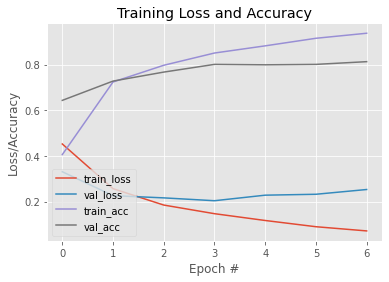

In [56]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), history4.history["loss"], label="train_loss")
plt.plot(np.arange(0, 7), history4.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 7), history4.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 7), history4.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [57]:
model4.evaluate(X_test, y_test, batch_size=20, verbose=2)    #[0.25827130675315857, 0.7975000143051147]

100/100 - 4s - loss: 0.2583 - accuracy: 0.7975 - 4s/epoch - 43ms/step


[0.25827130675315857, 0.7975000143051147]

In [58]:
model5 = Sequential()
model5.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model5.add(SpatialDropout1D(0.2))
model5.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model5.add(Dense(5, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_22 (Dense)            (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
history5 = model5.fit(X_train, y_train, epochs=7, validation_split=0.2)

Epoch 1/7
200/200 [==============================] - 132s 644ms/step - loss: 0.9849 - accuracy: 0.6108 - val_loss: 0.6642 - val_accuracy: 0.7644
Epoch 2/7
200/200 [==============================] - 126s 628ms/step - loss: 0.5678 - accuracy: 0.7987 - val_loss: 0.5814 - val_accuracy: 0.8031
Epoch 3/7
200/200 [==============================] - 127s 634ms/step - loss: 0.4568 - accuracy: 0.8394 - val_loss: 0.4914 - val_accuracy: 0.8250
Epoch 4/7
200/200 [==============================] - 126s 628ms/step - loss: 0.3736 - accuracy: 0.8714 - val_loss: 0.4939 - val_accuracy: 0.8350
Epoch 5/7
200/200 [==============================] - 126s 628ms/step - loss: 0.3124 - accuracy: 0.8927 - val_loss: 0.5024 - val_accuracy: 0.8462
Epoch 6/7
200/200 [==============================] - 125s 623ms/step - loss: 0.2617 - accuracy: 0.9097 - val_loss: 0.5072 - val_accuracy: 0.8388
Epoch 7/7
200/200 [==============================] - 125s 626ms/step - loss: 0.2206 - accuracy: 0.9255 - val_loss: 0.5133 - val_ac

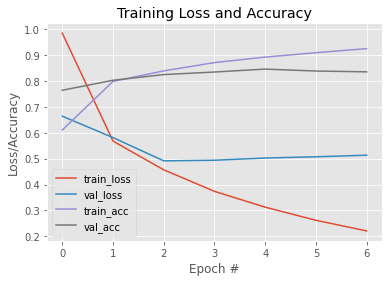

In [60]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), history5.history["loss"], label="train_loss")
plt.plot(np.arange(0, 7), history5.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 7), history5.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 7), history5.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [61]:
model5.evaluate(X_test, y_test, batch_size=20, verbose=2)    #[0.5509871244430542, 0.8255000114440918]

100/100 - 13s - loss: 0.5510 - accuracy: 0.8255 - 13s/epoch - 130ms/step


[0.5509871244430542, 0.8255000114440918]

In [62]:
model6 = Sequential()
model6.add(Embedding(maxWords, embVec, input_length=features.shape[1]))
model6.add(SpatialDropout1D(0.2))
model6.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model6.add(Dense(5, activation='sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model6.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_23 (Dense)            (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history6 = model6.fit(X_train, y_train, epochs=7, validation_split=0.2)

Epoch 1/7
200/200 [==============================] - 132s 650ms/step - loss: 0.3776 - accuracy: 0.5550 - val_loss: 0.2644 - val_accuracy: 0.7219
Epoch 2/7
200/200 [==============================] - 147s 738ms/step - loss: 0.2057 - accuracy: 0.7817 - val_loss: 0.1857 - val_accuracy: 0.8169
Epoch 3/7
200/200 [==============================] - 132s 658ms/step - loss: 0.1466 - accuracy: 0.8573 - val_loss: 0.1798 - val_accuracy: 0.8175
Epoch 4/7
200/200 [==============================] - 134s 672ms/step - loss: 0.1100 - accuracy: 0.8914 - val_loss: 0.1886 - val_accuracy: 0.8138
Epoch 5/7
200/200 [==============================] - 131s 656ms/step - loss: 0.0824 - accuracy: 0.9237 - val_loss: 0.2180 - val_accuracy: 0.8044
Epoch 6/7
200/200 [==============================] - 163s 814ms/step - loss: 0.0636 - accuracy: 0.9450 - val_loss: 0.2240 - val_accuracy: 0.8100
Epoch 7/7
200/200 [==============================] - 151s 756ms/step - loss: 0.0463 - accuracy: 0.9627 - val_loss: 0.2395 - val_ac

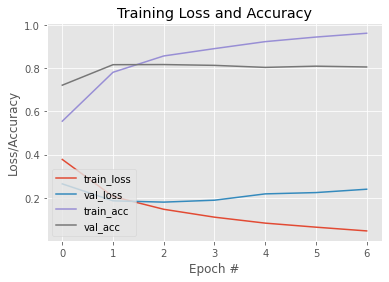

In [64]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), history6.history["loss"], label="train_loss")
plt.plot(np.arange(0, 7), history6.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 7), history6.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 7), history6.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [65]:
model6.evaluate(X_test, y_test, batch_size=20, verbose=2)   #[0.23404571413993835, 0.815500020980835]

100/100 - 13s - loss: 0.2340 - accuracy: 0.8155 - 13s/epoch - 126ms/step


[0.23404571413993835, 0.815500020980835]